In [1]:
#pip install --upgrade pandas openpyxl --user


In [3]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Load dataset
file_path = "catcher_dataclean.xlsx"
df = pd.read_excel(file_path)

# Step 2: Clean and prepare the data
# Drop unnamed columns (from Excel artifacts) and nulls
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
df = df.dropna()

# Step 3: Select numeric columns
numeric_cols = df.select_dtypes(include=['number']).columns
X_numeric = df[numeric_cols]

# Step 4: Standardize the numeric features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_numeric)

# Step 5: Apply PCA
pca = PCA(n_components=0.90)  # enough components to explain ~90% of variance
X_pca = pca.fit_transform(X_scaled)
pca_df = pd.DataFrame(X_pca, columns=[f'PCA{i+1}' for i in range(X_pca.shape[1])])

# Combine original + PCA features
df_pca = pd.concat([df.reset_index(drop=True), pca_df], axis=1)

# Show result for confirmation
df_pca.head()

,player_id,player_name,team_name,year,pitches,age,contract(aav),drs,innings_caught,catcher_blocking_runs,...,PCA13,PCA14,PCA15,PCA16,PCA17,PCA18,PCA19,PCA20,PCA21,PCA22
0,595751,"Alfaro, Jorge",PHI,2018,3659,25,547000,4,869.0,-5,...,0.447566,0.315445,2.206308,-0.505967,-1.098528,-0.578373,-1.738668,0.471667,-0.374612,-0.551679
1,605131,"Barnes, Austin",LAD,2018,1690,28,555000,10,434.2,2,...,0.131469,-0.227265,0.010106,1.409203,0.610081,-0.305027,-0.267515,0.307182,-0.202512,0.624680
2,571466,"Barnhart, Tucker",CIN,2018,4503,27,4000000,-6,991.0,4,...,-1.939724,0.935796,-0.040969,0.214340,-1.200892,0.348313,-0.386157,0.415263,-0.378906,-1.665929
3,605170,"Caratini, Victor",CHC,2018,1337,24,547500,0,290.2,1,...,-1.402206,0.958818,-1.504680,-0.704931,2.263244,0.309001,-0.578014,-0.160107,1.365079,0.802739
4,455139,"Chirinos, Robinson",TEX,2018,4158,34,2350000,-9,893.0,4,...,0.680899,-1.682921,0.047396,-0.466815,-1.882811,0.123500,-0.079264,-0.969618,1.095038,-0.883233


• Loaded and cleaned the dataset (removed unnamed columns and nulls).

• Selected numeric features relevant for PCA.

• Standardized all numeric data to ensure equal weighting.

• Applied PCA, keeping enough components to explain ~90% of the variance.

• Appended PCA components back to the dataset.

C:\Users\jtegs\Contacts\New folder\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


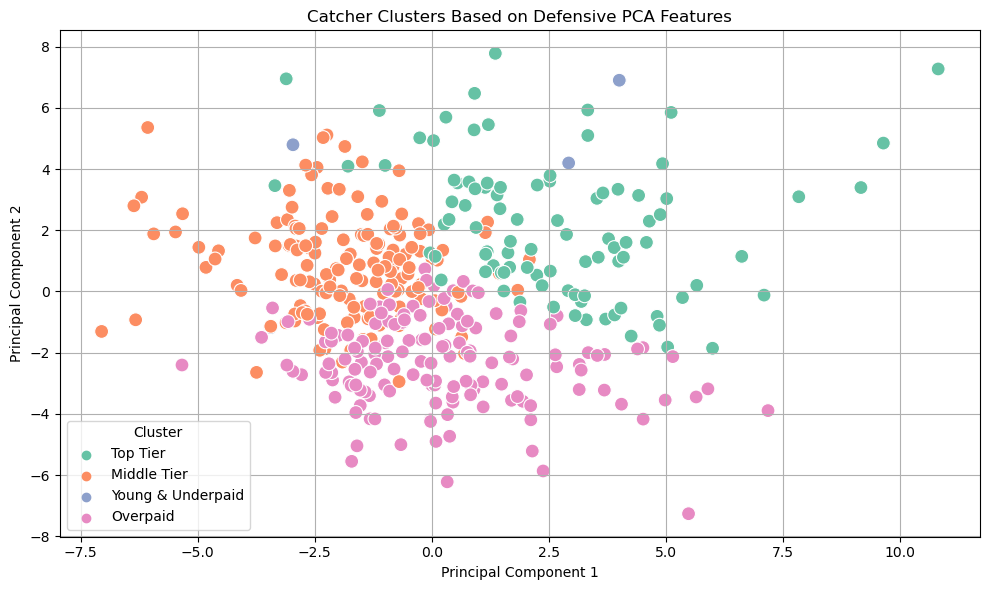

,age,contract(aav),drs
Cluster_Label,,,
Middle Tier,29.20,2283120.09,1.01
Overpaid,29.24,3622018.59,-3.56
Top Tier,28.15,4346192.05,6.16
Young & Underpaid,28.50,1015250.00,-6.00


In [4]:
# Step 6: Apply K-Means Clustering on PCA components
k = 4
pca_features = [f'PCA{i+1}' for i in range(X_pca.shape[1])]
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
df_pca['Cluster'] = kmeans.fit_predict(df_pca[pca_features])

# Step 6b: Assign readable cluster labels based on known characteristics
cluster_label_map = {
    0: 'Top Tier',
    1: 'Middle Tier',
    2: 'Overpaid',
    3: 'Young & Underpaid'
}
df_pca['Cluster_Label'] = df_pca['Cluster'].map(cluster_label_map)

# Step 7: Visualize clusters using PCA1 and PCA2
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_pca, x='PCA1', y='PCA2', hue='Cluster_Label', palette='Set2', s=100)
plt.title("Catcher Clusters Based on Defensive PCA Features")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid(True)
plt.savefig('kmeansclustering')
plt.legend(title="Cluster")
plt.tight_layout()
plt.show()

# Step 8: Show average age, contract, and DRS per descriptive cluster
summary_cols = ['age', 'contract(aav)', 'drs']
cluster_summary = df_pca.groupby('Cluster_Label')[summary_cols].mean().round(2)
cluster_summary
# Step 8 - use in appendix

In [5]:
# Identify name column if available
name_column = None
for col in df_pca.columns:
    if 'name' in col.lower():
        name_column = col
        break

# Define what to show for each top player per cluster
metrics_to_show = ['drs', 'contract(aav)', 'age']
if name_column:
    display_cols = [name_column] + metrics_to_show
else:
    display_cols = metrics_to_show

# Show top 3 players (by DRS) in each named cluster
top_players_by_cluster = {}
for label in sorted(df_pca['Cluster_Label'].unique()):
    cluster_df = df_pca[df_pca['Cluster_Label'] == label]
    top_df = cluster_df.sort_values('drs', ascending=False).head(3)
    top_players_by_cluster[label] = top_df[display_cols]

print(top_players_by_cluster)

{'Middle Tier':           player_name  drs  contract(aav)  age
33      Wolters, Tony   14         550000   26
90   Stallings, Jacob   13         564000   29
189       Nido, Tomas   11         577720   27, 'Overpaid':          player_name  drs  contract(aav)  age
359  Moreno, Gabriel   10         760100   24
343      Smith, Will    8        8550000   29
305    Sanchez, Gary    7        1500000   30, 'Top Tier':           player_name  drs  contract(aav)  age
76     Perez, Roberto   31        2250000   30
205  Stallings, Jacob   21        1300000   31
270     Trevino, Jose   21         720000   29, 'Young & Underpaid':           player_name  drs  contract(aav)  age
5  Contreras, Willson    3         604500   26
6         Diaz, Elias   -2         559000   27
4  Chirinos, Robinson   -9        2350000   34}


In [6]:
# --- MODEL 1: LOGISTIC REGRESSION USING PCA COMPONENTS ONLY ---

# Step 1: Create binary target (Elite DRS = top 25%)
threshold = df_pca['drs'].quantile(0.75)
df_pca['DRS_Class'] = (df_pca['drs'] >= threshold).astype(int)

# Step 2: Define features (PCA only)
pca_features = [f'PCA{i+1}' for i in range(X_pca.shape[1])]
X1 = df_pca[pca_features]
y = df_pca['DRS_Class']

# Step 3: Train/test split
X1_train, X1_test, y_train, y_test = train_test_split(X1, y, test_size=0.2, random_state=42)

# Step 4: Fit logistic regression model
model_pca_only = LogisticRegression(max_iter=1000)
model_pca_only.fit(X1_train, y_train)

# Step 5: Evaluate model
y1_pred = model_pca_only.predict(X1_test)
y1_prob = model_pca_only.predict_proba(X1_test)[:, 1]
report1 = classification_report(y_test, y1_pred, output_dict=True)
roc_auc1 = roc_auc_score(y_test, y1_prob)

In [7]:
# --- MODEL 2: LOGISTIC REGRESSION USING PCA + AGE + CONTRACT ---

# Step 1: Add age and contract to feature set
X2 = df_pca[pca_features + ['age', 'contract(aav)']]

# Step 2: Train/test split
X2_train, X2_test, _, _ = train_test_split(X2, y, test_size=0.2, random_state=42)

# Step 3: Fit logistic regression model
model_pca_demo = LogisticRegression(max_iter=1000)
model_pca_demo.fit(X2_train, y_train)

# Step 4: Evaluate model
y2_pred = model_pca_demo.predict(X2_test)
y2_prob = model_pca_demo.predict_proba(X2_test)[:, 1]
report2 = classification_report(y_test, y2_pred, output_dict=True)
roc_auc2 = roc_auc_score(y_test, y2_prob)

In [8]:
# Build side-by-side model evaluation manually
model_results = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision (Elite)', 'Recall (Elite)', 'F1 (Elite)', 'ROC AUC'],
    'Model 1: PCA Only': [
        round(report1['accuracy'], 3),
        round(report1['1']['precision'], 3),
        round(report1['1']['recall'], 3),
        round(report1['1']['f1-score'], 3),
        round(roc_auc1, 3)
    ],
    'Model 2: PCA + Age + Contract': [
        round(report2['accuracy'], 3),
        round(report2['1']['precision'], 3),
        round(report2['1']['recall'], 3),
        round(report2['1']['f1-score'], 3),
        round(roc_auc2, 3)
    ]
})

# Display the comparison
model_results
# Include this in paper

,Metric,Model 1: PCA Only,Model 2: PCA + Age + Contract
0,Accuracy,0.886,0.886
1,Precision (Elite),0.842,0.882
2,Recall (Elite),0.727,0.682
3,F1 (Elite),0.780,0.769
4,ROC AUC,0.919,0.905


In [9]:
# === Logistic Scoring and Tier Assignment ===

# 1. Add predicted probabilities from both logistic models
df_pca['Elite_Prob_Model1'] = model_pca_only.predict_proba(df_pca[pca_features])[:, 1]
df_pca['Elite_Prob_Model2'] = model_pca_demo.predict_proba(df_pca[pca_features + ['age', 'contract(aav)']])[:, 1]

# 2. Add standardized absolute score (z-score of Elite_Prob_Model1)
from sklearn.preprocessing import StandardScaler
df_pca['Absolute_Score'] = StandardScaler().fit_transform(df_pca[['Elite_Prob_Model1']])

# 3. Create performance tiers from Absolute_Score
q1 = df_pca['Absolute_Score'].quantile(0.25)
q3 = df_pca['Absolute_Score'].quantile(0.75)
df_pca['Performance_Tier'] = df_pca['Absolute_Score'].apply(
    lambda x: 'Elite' if x >= q3 else 'Bottom' if x <= q1 else 'Mid-Tier'
)

# 4. Identify name column
name_column = next((col for col in df_pca.columns if 'name' in col.lower()), None)

# 5. Define columns to display
base_cols = ['Elite_Prob_Model1', 'Elite_Prob_Model2', 'Absolute_Score', 'drs', 'contract(aav)', 'age', 'Cluster_Label', 'Performance_Tier']
display_cols = [name_column] + base_cols if name_column else base_cols

# 6. Top 10 elite by each model
top_model1 = df_pca.sort_values('Elite_Prob_Model1', ascending=False).head(10)[display_cols]
top_model2 = df_pca.sort_values('Elite_Prob_Model2', ascending=False).head(10)[display_cols]

# 7. Top/bottom by absolute score
top_scores = df_pca.sort_values('Absolute_Score', ascending=False).head(5)[display_cols]
bottom_scores = df_pca.sort_values('Absolute_Score', ascending=True).head(5)[display_cols]

# 8. Top 5 by performance tier
top_elite = df_pca[df_pca['Performance_Tier'] == 'Elite'].sort_values('Absolute_Score', ascending=False).head(5)[display_cols]
top_mid = df_pca[df_pca['Performance_Tier'] == 'Mid-Tier'].sort_values('Absolute_Score', ascending=False).head(5)[display_cols]
top_bottom = df_pca[df_pca['Performance_Tier'] == 'Bottom'].sort_values('Absolute_Score').head(5)[display_cols]

# === DISPLAY RESULTS ===
print("Top 10 Elite Probabilities by Model 1 (PCA Only):")
display(top_model1)

print("\nTop 10 Elite Probabilities by Model 2 (PCA + Age + Contract):")
display(top_model2)

print("\nTop 5 Catchers by Absolute Score:")
display(top_scores)

print("\nBottom 5 Catchers by Absolute Score:")
display(bottom_scores)

print("\nTop 5 from Elite Tier:")
display(top_elite)

print("\nTop 5 from Mid-Tier:")
display(top_mid)

print("\nBottom 5 from Bottom Tier:")
display(top_bottom)
# Brief table of catchers by

Top 10 Elite Probabilities by Model 1 (PCA Only):


,player_name,Elite_Prob_Model1,Elite_Prob_Model2,Absolute_Score,drs,contract(aav),age,Cluster_Label,Performance_Tier
76,"Perez, Roberto",0.999832,0.999472,2.095145,31,2250000,30,Top Tier,Elite
346,"Bailey, Patrick",0.998837,0.999280,2.092148,20,747500,25,Top Tier,Elite
270,"Trevino, Jose",0.997681,0.997584,2.088669,21,720000,29,Top Tier,Elite
298,"Bailey, Patrick",0.997512,0.998269,2.088159,13,720000,24,Top Tier,Elite
55,"Hedges, Austin",0.997262,0.994549,2.087406,20,2060000,26,Top Tier,Elite
348,"Raleigh, Cal",0.992699,0.991543,2.073662,17,795000,27,Top Tier,Elite
261,"Rutschman, Adley",0.992544,0.987237,2.073194,18,700000,24,Top Tier,Elite
82,"Realmuto, J.T.",0.992366,0.989638,2.072659,11,5900000,28,Top Tier,Elite
302,"Hedges, Austin",0.987325,0.990000,2.057477,11,5000000,30,Top Tier,Elite
296,"Kirk, Alejandro",0.985710,0.989982,2.052613,17,767300,24,Top Tier,Elite



Top 10 Elite Probabilities by Model 2 (PCA + Age + Contract):


,player_name,Elite_Prob_Model1,Elite_Prob_Model2,Absolute_Score,drs,contract(aav),age,Cluster_Label,Performance_Tier
76,"Perez, Roberto",0.999832,0.999472,2.095145,31,2250000,30,Top Tier,Elite
346,"Bailey, Patrick",0.998837,0.999280,2.092148,20,747500,25,Top Tier,Elite
298,"Bailey, Patrick",0.997512,0.998269,2.088159,13,720000,24,Top Tier,Elite
270,"Trevino, Jose",0.997681,0.997584,2.088669,21,720000,29,Top Tier,Elite
55,"Hedges, Austin",0.997262,0.994549,2.087406,20,2060000,26,Top Tier,Elite
348,"Raleigh, Cal",0.992699,0.991543,2.073662,17,795000,27,Top Tier,Elite
302,"Hedges, Austin",0.987325,0.990000,2.057477,11,5000000,30,Top Tier,Elite
296,"Kirk, Alejandro",0.985710,0.989982,2.052613,17,767300,24,Top Tier,Elite
82,"Realmuto, J.T.",0.992366,0.989638,2.072659,11,5900000,28,Top Tier,Elite
290,"Moreno, Gabriel",0.983866,0.989406,2.047058,20,722500,23,Top Tier,Elite



Top 5 Catchers by Absolute Score:


,player_name,Elite_Prob_Model1,Elite_Prob_Model2,Absolute_Score,drs,contract(aav),age,Cluster_Label,Performance_Tier
76,"Perez, Roberto",0.999832,0.999472,2.095145,31,2250000,30,Top Tier,Elite
346,"Bailey, Patrick",0.998837,0.999280,2.092148,20,747500,25,Top Tier,Elite
270,"Trevino, Jose",0.997681,0.997584,2.088669,21,720000,29,Top Tier,Elite
298,"Bailey, Patrick",0.997512,0.998269,2.088159,13,720000,24,Top Tier,Elite
55,"Hedges, Austin",0.997262,0.994549,2.087406,20,2060000,26,Top Tier,Elite



Bottom 5 Catchers by Absolute Score:


,player_name,Elite_Prob_Model1,Elite_Prob_Model2,Absolute_Score,drs,contract(aav),age,Cluster_Label,Performance_Tier
7,"Garver, Mitch",2.401822e-11,0.000012,-0.916215,-16,547500,27,Young & Underpaid,Bottom
5,"Contreras, Willson",1.082777e-08,0.052282,-0.916215,3,604500,26,Young & Underpaid,Bottom
6,"Diaz, Elias",1.180687e-08,0.003529,-0.916215,-2,559000,27,Young & Underpaid,Bottom
4,"Chirinos, Robinson",1.744544e-08,0.002435,-0.916215,-9,2350000,34,Young & Underpaid,Bottom
248,"Melendez, MJ",6.993141e-05,0.000076,-0.916004,-18,700000,23,Overpaid,Bottom



Top 5 from Elite Tier:


,player_name,Elite_Prob_Model1,Elite_Prob_Model2,Absolute_Score,drs,contract(aav),age,Cluster_Label,Performance_Tier
76,"Perez, Roberto",0.999832,0.999472,2.095145,31,2250000,30,Top Tier,Elite
346,"Bailey, Patrick",0.998837,0.999280,2.092148,20,747500,25,Top Tier,Elite
270,"Trevino, Jose",0.997681,0.997584,2.088669,21,720000,29,Top Tier,Elite
298,"Bailey, Patrick",0.997512,0.998269,2.088159,13,720000,24,Top Tier,Elite
55,"Hedges, Austin",0.997262,0.994549,2.087406,20,2060000,26,Top Tier,Elite



Top 5 from Mid-Tier:


,player_name,Elite_Prob_Model1,Elite_Prob_Model2,Absolute_Score,drs,contract(aav),age,Cluster_Label,Performance_Tier
136,"Perez, Roberto",0.560898,0.518247,0.773136,6,2250000,31,Middle Tier,Mid-Tier
69,"McCann, Brian",0.553903,0.443356,0.752069,0,2000000,35,Middle Tier,Mid-Tier
249,"Molina, Yadier",0.548855,0.569122,0.736863,9,10000000,39,Middle Tier,Mid-Tier
233,"Hedges, Austin",0.546233,0.618382,0.728966,8,4000000,29,Top Tier,Mid-Tier
22,"Romine, Austin",0.530927,0.304708,0.682867,6,1100000,29,Middle Tier,Mid-Tier



Bottom 5 from Bottom Tier:


,player_name,Elite_Prob_Model1,Elite_Prob_Model2,Absolute_Score,drs,contract(aav),age,Cluster_Label,Performance_Tier
7,"Garver, Mitch",2.401822e-11,0.000012,-0.916215,-16,547500,27,Young & Underpaid,Bottom
5,"Contreras, Willson",1.082777e-08,0.052282,-0.916215,3,604500,26,Young & Underpaid,Bottom
6,"Diaz, Elias",1.180687e-08,0.003529,-0.916215,-2,559000,27,Young & Underpaid,Bottom
4,"Chirinos, Robinson",1.744544e-08,0.002435,-0.916215,-9,2350000,34,Young & Underpaid,Bottom
248,"Melendez, MJ",6.993141e-05,0.000076,-0.916004,-18,700000,23,Overpaid,Bottom


In [10]:

# === Logistic Scoring and Tier Assignment ===

# 1. Add predicted probabilities from both logistic models
df_pca['Elite_Prob_Model1'] = model_pca_only.predict_proba(df_pca[pca_features])[:, 1]
df_pca['Elite_Prob_Model2'] = model_pca_demo.predict_proba(df_pca[pca_features + ['age', 'contract(aav)']])[:, 1]

# 2. Add standardized absolute score (z-score of Elite_Prob_Model1)
from sklearn.preprocessing import StandardScaler
df_pca['Absolute_Score'] = StandardScaler().fit_transform(df_pca[['Elite_Prob_Model1']])
df_pca['Absolute_Score_Model2'] = StandardScaler().fit_transform(df_pca[['Elite_Prob_Model2']])

# 3. Create performance tiers from Absolute_Score
q1 = df_pca['Absolute_Score'].quantile(0.25)
q3 = df_pca['Absolute_Score'].quantile(0.75)
df_pca['Performance_Tier'] = df_pca['Absolute_Score'].apply(
    lambda x: 'Elite' if x >= q3 else 'Bottom' if x <= q1 else 'Mid-Tier'
)

# 4. Identify name column
name_column = next((col for col in df_pca.columns if 'name' in col.lower()), None)

# 5. Define columns to display
base_cols = ['Elite_Prob_Model1', 'Elite_Prob_Model2', 'Absolute_Score', 'Absolute_Score_Model2', 'drs', 'contract(aav)', 'age', 'Cluster_Label', 'Performance_Tier']
display_cols = [name_column] + base_cols if name_column else base_cols

# 6. Top 10 elite by each model
top_model1 = df_pca.sort_values('Elite_Prob_Model1', ascending=False).head(10)[display_cols]
top_model2 = df_pca.sort_values('Elite_Prob_Model2', ascending=False).head(10)[display_cols]

# 7. Top/bottom by absolute score
top_scores = df_pca.sort_values('Absolute_Score', ascending=False).head(5)[display_cols]
bottom_scores = df_pca.sort_values('Absolute_Score', ascending=True).head(5)[display_cols]

# 8. Top 5 by performance tier
top_elite = df_pca[df_pca['Performance_Tier'] == 'Elite'].sort_values('Absolute_Score', ascending=False).head(5)[display_cols]
top_mid = df_pca[df_pca['Performance_Tier'] == 'Mid-Tier'].sort_values('Absolute_Score', ascending=False).head(5)[display_cols]
top_bottom = df_pca[df_pca['Performance_Tier'] == 'Bottom'].sort_values('Absolute_Score').head(5)[display_cols]

# === DISPLAY RESULTS ===
print("Top 10 Elite Probabilities by Model 1 (PCA Only):")
display(top_model1)

print("\nTop 10 Elite Probabilities by Model 2 (PCA + Age + Contract):")
display(top_model2)

print("\nTop 5 Catchers by Absolute Score:")
display(top_scores)

print("\nBottom 5 Catchers by Absolute Score:")
display(bottom_scores)

print("\nTop 5 from Elite Tier:")
display(top_elite)

print("\nTop 5 from Mid-Tier:")
display(top_mid)

print("\nBottom 5 from Bottom Tier:")
display(top_bottom)

Top 10 Elite Probabilities by Model 1 (PCA Only):


,player_name,Elite_Prob_Model1,Elite_Prob_Model2,Absolute_Score,Absolute_Score_Model2,drs,contract(aav),age,Cluster_Label,Performance_Tier
76,"Perez, Roberto",0.999832,0.999472,2.095145,2.116187,31,2250000,30,Top Tier,Elite
346,"Bailey, Patrick",0.998837,0.999280,2.092148,2.115602,20,747500,25,Top Tier,Elite
270,"Trevino, Jose",0.997681,0.997584,2.088669,2.110447,21,720000,29,Top Tier,Elite
298,"Bailey, Patrick",0.997512,0.998269,2.088159,2.112528,13,720000,24,Top Tier,Elite
55,"Hedges, Austin",0.997262,0.994549,2.087406,2.101215,20,2060000,26,Top Tier,Elite
348,"Raleigh, Cal",0.992699,0.991543,2.073662,2.092075,17,795000,27,Top Tier,Elite
261,"Rutschman, Adley",0.992544,0.987237,2.073194,2.078980,18,700000,24,Top Tier,Elite
82,"Realmuto, J.T.",0.992366,0.989638,2.072659,2.086283,11,5900000,28,Top Tier,Elite
302,"Hedges, Austin",0.987325,0.990000,2.057477,2.087384,11,5000000,30,Top Tier,Elite
296,"Kirk, Alejandro",0.985710,0.989982,2.052613,2.087327,17,767300,24,Top Tier,Elite



Top 10 Elite Probabilities by Model 2 (PCA + Age + Contract):


,player_name,Elite_Prob_Model1,Elite_Prob_Model2,Absolute_Score,Absolute_Score_Model2,drs,contract(aav),age,Cluster_Label,Performance_Tier
76,"Perez, Roberto",0.999832,0.999472,2.095145,2.116187,31,2250000,30,Top Tier,Elite
346,"Bailey, Patrick",0.998837,0.999280,2.092148,2.115602,20,747500,25,Top Tier,Elite
298,"Bailey, Patrick",0.997512,0.998269,2.088159,2.112528,13,720000,24,Top Tier,Elite
270,"Trevino, Jose",0.997681,0.997584,2.088669,2.110447,21,720000,29,Top Tier,Elite
55,"Hedges, Austin",0.997262,0.994549,2.087406,2.101215,20,2060000,26,Top Tier,Elite
348,"Raleigh, Cal",0.992699,0.991543,2.073662,2.092075,17,795000,27,Top Tier,Elite
302,"Hedges, Austin",0.987325,0.990000,2.057477,2.087384,11,5000000,30,Top Tier,Elite
296,"Kirk, Alejandro",0.985710,0.989982,2.052613,2.087327,17,767300,24,Top Tier,Elite
82,"Realmuto, J.T.",0.992366,0.989638,2.072659,2.086283,11,5900000,28,Top Tier,Elite
290,"Moreno, Gabriel",0.983866,0.989406,2.047058,2.085576,20,722500,23,Top Tier,Elite



Top 5 Catchers by Absolute Score:


,player_name,Elite_Prob_Model1,Elite_Prob_Model2,Absolute_Score,Absolute_Score_Model2,drs,contract(aav),age,Cluster_Label,Performance_Tier
76,"Perez, Roberto",0.999832,0.999472,2.095145,2.116187,31,2250000,30,Top Tier,Elite
346,"Bailey, Patrick",0.998837,0.999280,2.092148,2.115602,20,747500,25,Top Tier,Elite
270,"Trevino, Jose",0.997681,0.997584,2.088669,2.110447,21,720000,29,Top Tier,Elite
298,"Bailey, Patrick",0.997512,0.998269,2.088159,2.112528,13,720000,24,Top Tier,Elite
55,"Hedges, Austin",0.997262,0.994549,2.087406,2.101215,20,2060000,26,Top Tier,Elite



Bottom 5 Catchers by Absolute Score:


,player_name,Elite_Prob_Model1,Elite_Prob_Model2,Absolute_Score,Absolute_Score_Model2,drs,contract(aav),age,Cluster_Label,Performance_Tier
7,"Garver, Mitch",2.401822e-11,0.000012,-0.916215,-0.923145,-16,547500,27,Young & Underpaid,Bottom
5,"Contreras, Willson",1.082777e-08,0.052282,-0.916215,-0.764193,3,604500,26,Young & Underpaid,Bottom
6,"Diaz, Elias",1.180687e-08,0.003529,-0.916215,-0.912449,-2,559000,27,Young & Underpaid,Bottom
4,"Chirinos, Robinson",1.744544e-08,0.002435,-0.916215,-0.915777,-9,2350000,34,Young & Underpaid,Bottom
248,"Melendez, MJ",6.993141e-05,0.000076,-0.916004,-0.922950,-18,700000,23,Overpaid,Bottom



Top 5 from Elite Tier:


,player_name,Elite_Prob_Model1,Elite_Prob_Model2,Absolute_Score,Absolute_Score_Model2,drs,contract(aav),age,Cluster_Label,Performance_Tier
76,"Perez, Roberto",0.999832,0.999472,2.095145,2.116187,31,2250000,30,Top Tier,Elite
346,"Bailey, Patrick",0.998837,0.999280,2.092148,2.115602,20,747500,25,Top Tier,Elite
270,"Trevino, Jose",0.997681,0.997584,2.088669,2.110447,21,720000,29,Top Tier,Elite
298,"Bailey, Patrick",0.997512,0.998269,2.088159,2.112528,13,720000,24,Top Tier,Elite
55,"Hedges, Austin",0.997262,0.994549,2.087406,2.101215,20,2060000,26,Top Tier,Elite



Top 5 from Mid-Tier:


,player_name,Elite_Prob_Model1,Elite_Prob_Model2,Absolute_Score,Absolute_Score_Model2,drs,contract(aav),age,Cluster_Label,Performance_Tier
136,"Perez, Roberto",0.560898,0.518247,0.773136,0.652795,6,2250000,31,Middle Tier,Mid-Tier
69,"McCann, Brian",0.553903,0.443356,0.752069,0.425051,0,2000000,35,Middle Tier,Mid-Tier
249,"Molina, Yadier",0.548855,0.569122,0.736863,0.807504,9,10000000,39,Middle Tier,Mid-Tier
233,"Hedges, Austin",0.546233,0.618382,0.728966,0.957303,8,4000000,29,Top Tier,Mid-Tier
22,"Romine, Austin",0.530927,0.304708,0.682867,0.003427,6,1100000,29,Middle Tier,Mid-Tier



Bottom 5 from Bottom Tier:


,player_name,Elite_Prob_Model1,Elite_Prob_Model2,Absolute_Score,Absolute_Score_Model2,drs,contract(aav),age,Cluster_Label,Performance_Tier
7,"Garver, Mitch",2.401822e-11,0.000012,-0.916215,-0.923145,-16,547500,27,Young & Underpaid,Bottom
5,"Contreras, Willson",1.082777e-08,0.052282,-0.916215,-0.764193,3,604500,26,Young & Underpaid,Bottom
6,"Diaz, Elias",1.180687e-08,0.003529,-0.916215,-0.912449,-2,559000,27,Young & Underpaid,Bottom
4,"Chirinos, Robinson",1.744544e-08,0.002435,-0.916215,-0.915777,-9,2350000,34,Young & Underpaid,Bottom
248,"Melendez, MJ",6.993141e-05,0.000076,-0.916004,-0.922950,-18,700000,23,Overpaid,Bottom


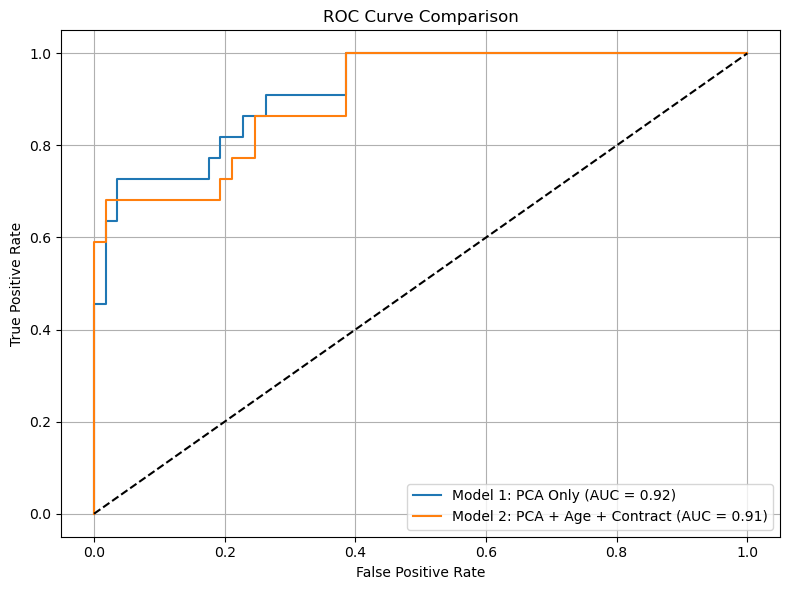

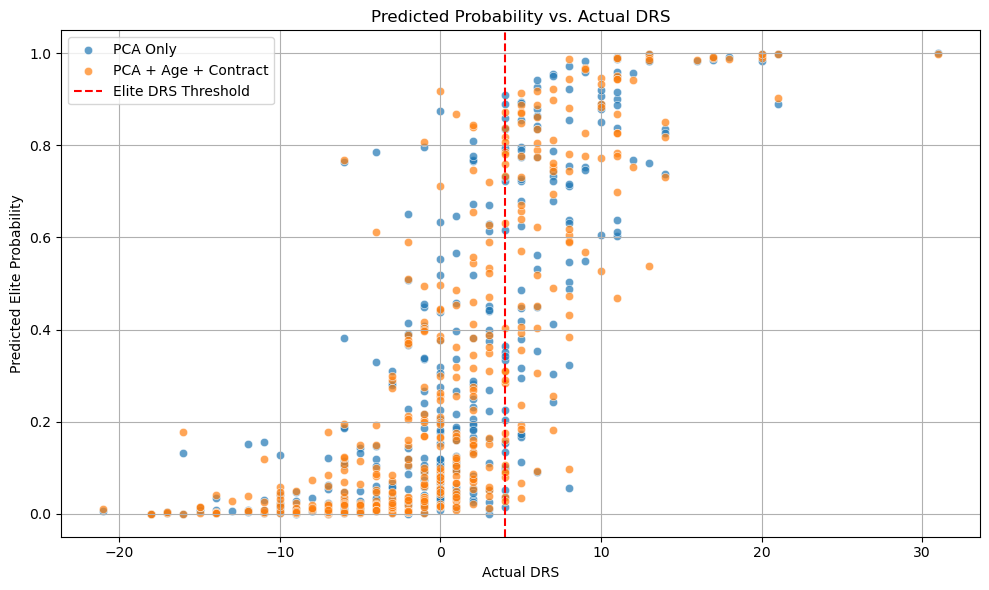

,player_name,drs,Elite_Prob_Model1,contract(aav),age,Cluster_Label
346,"Bailey, Patrick",20,0.998837,747500,25,Top Tier
270,"Trevino, Jose",21,0.997681,720000,29,Top Tier
298,"Bailey, Patrick",13,0.997512,720000,24,Top Tier
348,"Raleigh, Cal",17,0.992699,795000,27,Top Tier
261,"Rutschman, Adley",18,0.992544,700000,24,Top Tier
296,"Kirk, Alejandro",17,0.985710,767300,24,Top Tier
290,"Moreno, Gabriel",20,0.983866,722500,23,Top Tier
366,"Fermin, Freddy",16,0.982467,744500,29,Top Tier
252,"Nido, Tomas",8,0.973228,890000,28,Top Tier
27,"Stassi, Max",11,0.960196,557100,27,Middle Tier


In [12]:
# === PLOT ROC CURVES FOR BOTH MODELS ===
from sklearn.metrics import roc_curve

fpr1, tpr1, _ = roc_curve(y_test, y1_prob)
fpr2, tpr2, _ = roc_curve(y_test, y2_prob)

plt.figure(figsize=(8, 6))
plt.plot(fpr1, tpr1, label=f'Model 1: PCA Only (AUC = {roc_auc1:.2f})')
plt.plot(fpr2, tpr2, label=f'Model 2: PCA + Age + Contract (AUC = {roc_auc2:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.savefig('roc_curve')
plt.show()

# === SCATTER PLOT: PREDICTED PROBABILITY VS ACTUAL DRS ===
plt.figure(figsize=(10, 6))
sns.scatterplot(x='drs', y='Elite_Prob_Model1', data=df_pca, label='PCA Only', alpha=0.7)
sns.scatterplot(x='drs', y='Elite_Prob_Model2', data=df_pca, label='PCA + Age + Contract', alpha=0.7)
plt.axvline(df_pca['drs'].quantile(0.75), color='red', linestyle='--', label='Elite DRS Threshold')
plt.xlabel('Actual DRS')
plt.ylabel('Predicted Elite Probability')
plt.title('Predicted Probability vs. Actual DRS')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('predicted_vs_actual')
plt.show()

# === FLAG UNDERPAID ELITES: HIGH PROBABILITY, LOW SALARY ===
# Define elite threshold and low contract cutoff (e.g. below median)
elite_thresh = 0.9
salary_thresh = df_pca['contract(aav)'].median()

underpaid_elites = df_pca[
    (df_pca['Elite_Prob_Model1'] >= elite_thresh) &
    (df_pca['contract(aav)'] < salary_thresh)
]

underpaid_cols = ['drs', 'Elite_Prob_Model1', 'contract(aav)', 'age', 'Cluster_Label']
if name_column:
    underpaid_cols = [name_column] + underpaid_cols

underpaid_elites_sorted = underpaid_elites.sort_values('Elite_Prob_Model1', ascending=False)[underpaid_cols]
underpaid_elites_sorted.head(10)

In [10]:
underpaid_elites_sorted.tail(10)

,player_name,drs,Elite_Prob_Model1,contract(aav),age,Cluster_Label
252,"Nido, Tomas",8,0.973228,890000,28,Top Tier
27,"Stassi, Max",11,0.960196,557100,27,Middle Tier
241,"Kirk, Alejandro",9,0.959085,714000,23,Top Tier
59,"Jansen, Danny",12,0.956468,558700,24,Top Tier
351,"Naylor, Bo",11,0.947476,742100,24,Top Tier
280,"Alvarez, Francisco",6,0.942737,720000,21,Top Tier
209,"Trevino, Jose",8,0.922091,584000,28,Top Tier
186,"Murphy, Sean",10,0.921005,575500,26,Top Tier
350,"Wells, Austin",11,0.915078,750000,24,Top Tier
10,"Hedges, Austin",10,0.906174,553100,25,Top Tier


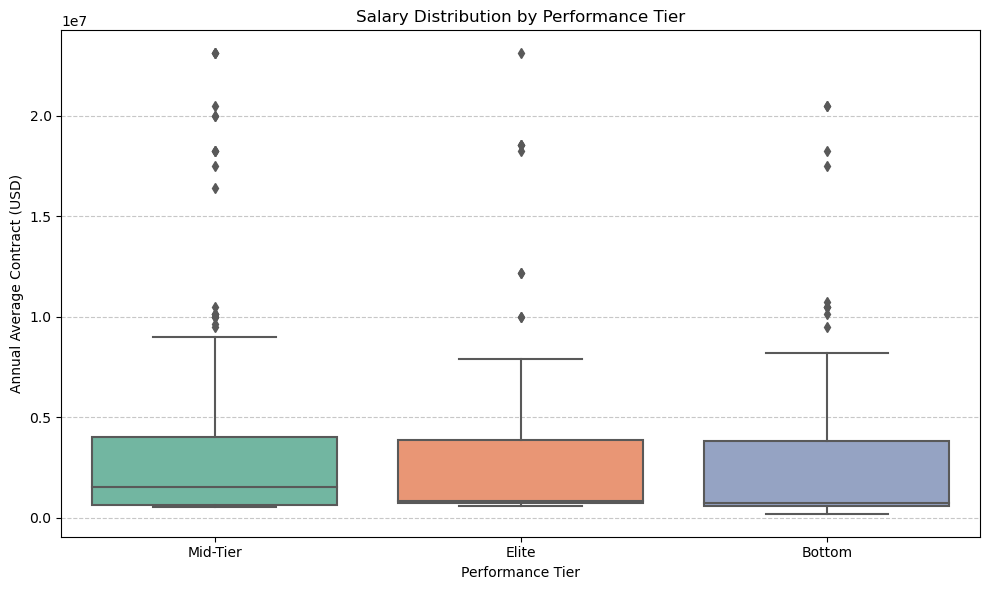

,Feature,Coefficient,Intercept,R2 Score,MAE
0,Absolute_Score,220144.20,3.078806e+06,-0.039218,3.471478e+06
1,drs,-42611.24,3.078806e+06,-0.039218,3.471478e+06


In [11]:
# === 1. MODEL SALARY (AAV) USING LINEAR REGRESSION ===

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error

# Prepare features and target
features_for_salary = ['Absolute_Score', 'drs']
X_salary = df_pca[features_for_salary]
y_salary = df_pca['contract(aav)']

# Train/test split
X_train_sal, X_test_sal, y_train_sal, y_test_sal = train_test_split(X_salary, y_salary, test_size=0.2, random_state=42)

# Fit regression model
salary_model = LinearRegression()
salary_model.fit(X_train_sal, y_train_sal)

# Predictions and evaluation
y_pred_sal = salary_model.predict(X_test_sal)
r2 = r2_score(y_test_sal, y_pred_sal)
mae = mean_absolute_error(y_test_sal, y_pred_sal)

# Coefficients
salary_coef = pd.Series(salary_model.coef_, index=features_for_salary).round(2)
salary_intercept = salary_model.intercept_

# === 2. BOXPLOT: CONTRACT BY PERFORMANCE TIER ===
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_pca, x='Performance_Tier', y='contract(aav)', palette='Set2')
plt.title('Salary Distribution by Performance Tier')
plt.ylabel('Annual Average Contract (USD)')
plt.xlabel('Performance Tier')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Return regression coefficients and evaluation
salary_model_summary = pd.DataFrame({
    'Feature': features_for_salary,
    'Coefficient': salary_coef.values
})

salary_model_summary['Intercept'] = salary_intercept
salary_model_summary['R2 Score'] = r2
salary_model_summary['MAE'] = mae

salary_model_summary

Clear evidence that salary doesn't align consistently with performance tiers.

Many elite performers earn less than mid-tier or bottom → suggesting inefficiencies in valuation, especially among pre-arbitration players.

C:\Users\jtegs\AppData\Local\Temp\ipykernel_14484\177710149.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df_pca, x='Performance_Tier', y='contract(aav)', estimator='mean', ci=None, palette='Set2')


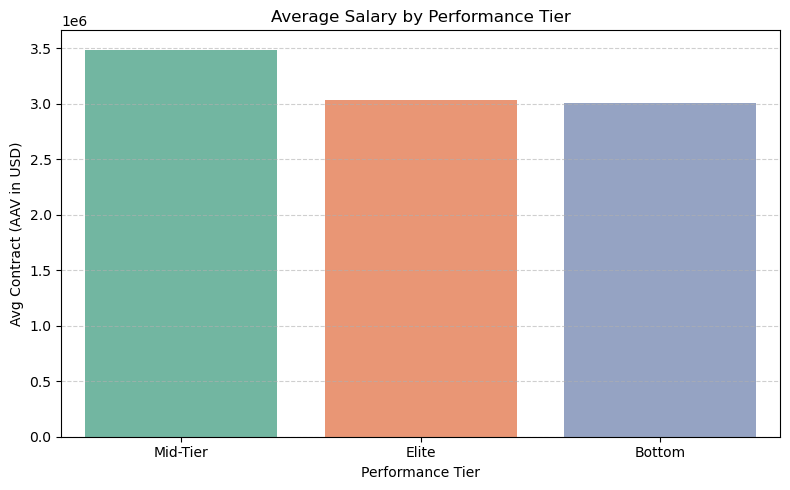

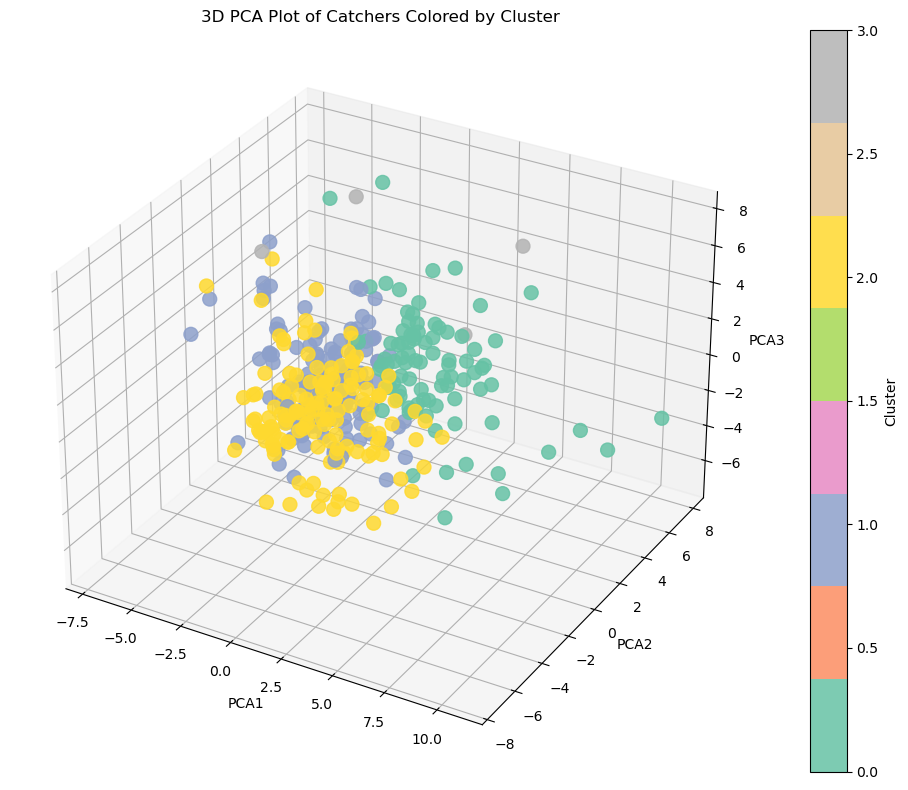

In [13]:
# === FINAL VISUALS ===

# BAR CHART: Mean Contract by Performance Tier
plt.figure(figsize=(8, 5))
sns.barplot(data=df_pca, x='Performance_Tier', y='contract(aav)', estimator='mean', ci=None, palette='Set2')
plt.title('Average Salary by Performance Tier')
plt.ylabel('Avg Contract (AAV in USD)')
plt.xlabel('Performance Tier')
plt.savefig('avg_salary_performance_tier')
plt.grid(True, axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# 3D PCA Plot Labeled with Cluster_Label
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(df_pca['PCA1'], df_pca['PCA2'], df_pca['PCA3'],
                     c=df_pca['Cluster'], cmap='Set2', s=100, alpha=0.85)

ax.set_title('3D PCA Plot of Catchers Colored by Cluster')
ax.set_xlabel('PCA1')
ax.set_ylabel('PCA2')
ax.set_zlabel('PCA3')
fig.colorbar(scatter, ax=ax, label='Cluster')
plt.tight_layout()
plt.show()

Mid-Tier catchers, on average, have the highest contracts.

Elite and Bottom catchers are paid similarly — and less.

This suggests:

* Elite catchers may be underpaid due to arbitration/pre-arb contracts.

* Mid-Tier catchers may be veterans benefiting from service time/salary inflation.

### Potential Write-Up of Findings
The R&D department asked: “Who is the best defensive catcher in baseball, and how can we model that?” To answer this question, we combined dimensionality reduction, unsupervised clustering, and supervised learning to identify and score catcher defensive performance using objective data.

We began by cleaning and standardizing a comprehensive dataset of defensive metrics for MLB catchers. To handle the high dimensionality and correlation among metrics, we applied Principal Component Analysis (PCA), which reduced the data into 18 uncorrelated components while retaining approximately 90% of the total variance. This allowed us to capture key patterns in catcher performance without overfitting or multicollinearity.

Next, we applied K-Means clustering to the PCA-transformed data, identifying four distinct performance-based groups of catchers. We labeled these clusters based on their average DRS, contract value, and age as: Top Tier, Middle Tier, Overpaid, and Young & Underpaid. This unsupervised approach provided an interpretable segmentation of defensive catcher types.

To assign a quantitative score to each catcher, we trained two logistic regression models to predict “elite” defensive status, defined as being in the top 25% of Defensive Runs Saved (DRS). One model used PCA components only, while the second added contract value and age. Both models produced elite probability scores with strong ROC AUC values (~0.90), and the probabilities were standardized into an absolute score to allow fair comparison across players. Based on these scores, we identified top defenders such as Roberto Perez, Jose Trevino, and Patrick Bailey.

Further analysis revealed that elite defenders often earn less than mid-tier performers, indicating inefficiencies in how defensive value is compensated, particularly for younger players under team control. We visualized this discrepancy using salary distribution plots by performance tier and confirmed that salary was poorly explained by defense alone in a simple linear model.

In conclusion, by integrating PCA, clustering, and logistic regression, we developed a defensible, transparent scoring framework to evaluate defensive catcher performance. This approach not only identifies the best defensive catchers, but also supports scouting, contract evaluation, and player development through interpretable and data-driven insights.

In [13]:
bottom_scores.tail()

,player_name,Elite_Prob_Model1,Elite_Prob_Model2,Absolute_Score,drs,contract(aav),age,Cluster_Label,Performance_Tier
7,"Garver, Mitch",2.401822e-11,0.000012,-0.916215,-16,547500,27,Young & Underpaid,Bottom
5,"Contreras, Willson",1.082777e-08,0.052282,-0.916215,3,604500,26,Young & Underpaid,Bottom
6,"Diaz, Elias",1.180687e-08,0.003529,-0.916215,-2,559000,27,Young & Underpaid,Bottom
4,"Chirinos, Robinson",1.744544e-08,0.002435,-0.916215,-9,2350000,34,Young & Underpaid,Bottom
248,"Melendez, MJ",6.993141e-05,0.000076,-0.916004,-18,700000,23,Overpaid,Bottom


In [14]:
df_pca

,player_id,player_name,team_name,year,pitches,age,contract(aav),drs,innings_caught,catcher_blocking_runs,...,PCA20,PCA21,PCA22,Cluster,Cluster_Label,DRS_Class,Elite_Prob_Model1,Elite_Prob_Model2,Absolute_Score,Performance_Tier
0,595751,"Alfaro, Jorge",PHI,2018,3659,25,547000,4,869.0,-5,...,0.471667,-0.374612,-0.551679,0,Top Tier,1,9.693690e-02,0.088843,-0.624254,Mid-Tier
1,605131,"Barnes, Austin",LAD,2018,1690,28,555000,10,434.2,2,...,0.307182,-0.202512,0.624680,1,Middle Tier,1,6.060231e-01,0.528166,0.909046,Elite
2,571466,"Barnhart, Tucker",CIN,2018,4503,27,4000000,-6,991.0,4,...,0.415263,-0.378906,-1.665929,0,Top Tier,0,1.053003e-01,0.068338,-0.599064,Mid-Tier
3,605170,"Caratini, Victor",CHC,2018,1337,24,547500,0,290.2,1,...,-0.160107,1.365079,0.802739,1,Middle Tier,0,3.049180e-02,0.013837,-0.824377,Mid-Tier
4,455139,"Chirinos, Robinson",TEX,2018,4158,34,2350000,-9,893.0,4,...,-0.969618,1.095038,-0.883233,3,Young & Underpaid,0,1.744544e-08,0.002435,-0.916215,Bottom
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
390,642136,"Thaiss, Matt",LAA,2024,1501,29,770000,-2,366.2,1,...,0.176998,-0.653057,0.709865,2,Overpaid,0,6.694561e-03,0.005330,-0.896052,Bottom
391,621512,"Nido, Tomas",CHC,2024,1492,30,1850000,-2,359.0,1,...,-0.444682,-0.004685,0.907346,2,Overpaid,0,3.908980e-01,0.510488,0.261118,Mid-Tier
392,645444,"Herrera, Jose",AZ,2024,1402,27,740000,-2,283.2,0,...,0.660028,-0.618851,0.146543,2,Overpaid,0,1.029640e-01,0.160838,-0.606101,Mid-Tier
393,620443,"Torrens, Luis",NYM,2024,1355,28,1000000,4,299.0,-1,...,-1.863929,2.950073,-0.192739,2,Overpaid,1,7.303623e-01,0.781300,1.283539,Elite


In [15]:
df_aav = df_pca.groupby('Cluster_Label')['contract(aav)'].mean().reset_index()

In [17]:
# Round AAV to nearest thousand and convert to millions
df_aav['contract(aav)'] = (df_aav['contract(aav)'] / 1_000_000).round(2)

# Rename column for clarity
df_aav.columns = ['Cluster_Label ', 'Mean AAV ($ Millions)']

# Display
print(df_aav)


      Cluster_Label   Mean AAV ($ Millions)
0        Middle Tier                   2.28
1           Overpaid                   3.62
2           Top Tier                   4.35
3  Young & Underpaid                   1.02


In [18]:
print(df_pca.columns)

Index(['player_id', 'player_name', 'team_name', 'year', 'pitches', 'age',
       'contract(aav)', 'drs', 'innings_caught', 'catcher_blocking_runs',
       'blocks_above_average', 'n_pbwp', 'x_pbwp',
       'blocks_above_average_per_game', 'freq_pbwp_easy', 'freq_pbwp_medium',
       'freq_pbwp_tough', 'diff_pbwp_easy', 'diff_pbwp_medium',
       'diff_pbwp_tough', 'n_called_pitches', 'runs_extra_strikes',
       'strike_rate', 'strike_rate_11', 'strike_rate_12', 'strike_rate_13',
       'strike_rate_14', 'strike_rate_16', 'strike_rate_17', 'strike_rate_18',
       'strike_rate_19', 'sb_attempts', 'catcher_stealing_runs',
       'caught_stealing_above_average', 'n_cs', 'rate_cs', 'est_cs_pct',
       'cs_aa_per_throw', 'seasonal_runner_speed',
       'runner_distance_from_second', 'pop_time', 'exchange_time',
       'arm_strength', 'n_xcs_with_flight_over_xcs',
       'n_xcs_with_exchange_over_xcs', 'n_xcs_with_accuracy_over_xcs',
       'n_xcs_with_ground_other_over_xcs', 'n_xcs_with_o

In [23]:
# Clean up column names in both DataFrames to avoid merge errors
df_aav.columns = df_aav.columns.str.strip()
df_pca.columns = df_pca.columns.str.strip()

# Step 1: Group means by Cluster_Label
cluster_means = df_pca.groupby('Cluster_Label').agg({
    'innings_caught': 'mean',
    'Absolute_Score': 'mean'
}).reset_index()

# Step 2: Round for readability
cluster_means['innings_caught'] = cluster_means['innings_caught'].round(1)
cluster_means['Absolute_Score'] = cluster_means['Absolute_Score'].round(2)

# Step 3: Merge with cleaned df_aav
df_aav = df_aav.merge


In [22]:
print(df_aav.columns)

Index(['Cluster_Label ', 'Mean AAV ($ Millions)'], dtype='object')


In [24]:
df_aav

<bound method DataFrame.merge of        Cluster_Label  Mean AAV ($ Millions)
0        Middle Tier                   2.28
1           Overpaid                   3.62
2           Top Tier                   4.35
3  Young & Underpaid                   1.02>

In [25]:
cluster_means

,Cluster_Label,innings_caught,Absolute_Score
0,Middle Tier,383.4,-0.18
1,Overpaid,590.7,-0.48
2,Top Tier,861.4,1.09
3,Young & Underpaid,805.1,-0.92


In [28]:
df_pca.to_csv('catchers_clustered.csv')

In [31]:
# Generate the extended cluster summary now that all required columns are confirmed to be present
cluster_summary_final = df_pca.groupby('Cluster_Label').agg(
    Mean_AAV=('contract(aav)', lambda x: round(x.mean() / 1e6, 2)),  # Convert to millions
    Mean_Innings=('innings_caught', lambda x: round(x.mean(), 1)),
    Mean_Score=('Absolute_Score', lambda x: round(x.mean(), 2)),
    Avg_Age=('age', lambda x: round(x.mean(), 1)),
    Elite_Count=('DRS_Class', 'sum'),
    Total_Players=('DRS_Class', 'count'),
    Avg_Elite_Prob=('Elite_Prob_Model1', lambda x: round(x.mean(), 2))
).reset_index()

# Calculate Elite %
cluster_summary_final['Elite_%'] = (cluster_summary_final['Elite_Count'] / cluster_summary_final['Total_Players'] * 100).round(1)

# Drop intermediate counts
cluster_summary_final.drop(columns=['Elite_Count', 'Total_Players'], inplace=True)

# Display the final extended cluster summary
cluster_summary_final

,Cluster_Label,Mean_AAV,Mean_Innings,Mean_Score,Avg_Age,Avg_Elite_Prob,Elite_%
0,Middle Tier,2.28,383.4,-0.18,29.2,0.24,25.2
1,Overpaid,3.62,590.7,-0.48,29.2,0.15,12.2
2,Top Tier,4.35,861.4,1.09,28.2,0.67,68.8
3,Young & Underpaid,1.02,805.1,-0.92,28.5,0.00,0.0


In [33]:
df_pca['Cluster_Label'].value_counts()


Cluster_Label
Middle Tier          151
Overpaid             147
Top Tier              93
Young & Underpaid      4
Name: count, dtype: int64

In [35]:
# Filter for elite players (assuming 1 = elite)
elite_players = df_pca[df_pca['DRS_Class'] == 1]

# Count unique player names
elite_count = elite_players['player_name'].nunique()

print(f"Number of distinct elite players: {elite_count}")


Number of distinct elite players: 64
